<a href="https://colab.research.google.com/github/IsaacFigNewton/Smishing-Detector/blob/sklearn-approach/Smishing_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO

<ol>
  <li>Reimplement the TF-IDF scoring system; Score = (token TF-IDF scores from ham) - (token TF-IDF scores from spam).</li>
  <li>Use regexes to parse, score, then replace emails, phone numbers, and URLs with a dummy string for later NLP.</li>
  <li>Handle common symbol replacements and letter substitutions.</li>
  <li>Use stemming and lemmatization to reduce the TFIDF token vector space.</li>
</ol>

# Import and config

## Install packages

In [1]:
!pip install -U sentence-transformers

In [2]:
!pip install bertopic

## Import Libraries

In [58]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import sparse
import nltk as nlp

from sklearn.pipeline import make_pipeline
from sklearn.metrics import *
from sklearn.metrics.pairwise import cosine_similarity,\
                                     cosine_distances

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans,\
                            SpectralClustering

In [59]:
# # TF-IDF
# from sklearn.feature_extraction.text import TfidfVectorizer

# Use BERT as the sentence encoder since it's the best open-source option
from sentence_transformers import SentenceTransformer

# use the bertopic text class vectorizer
from bertopic import BERTopic

## Set global variables

In [60]:
class_map = {"ham": 0, "spam": 1}
color_map = {0: "red", 0: "blue"}

char_ngrams = (1, 6)
word_ngrams = (1, 3)
minSusLen = 500
lenWeight = 0.01

In [61]:
np.random.seed(10)
random_state = 0

In [62]:
# Load a pretrained Sentence Transformer model
topic_model = BERTopic(n_gram_range=word_ngrams, calculate_probabilities=True)

# Load a pretrained Sentence Transformer model
sentence_embedder = SentenceTransformer("all-MiniLM-L6-v2")

# # create the vectorizer
# vec = TfidfVectorizer(ngram_range=word_ngrams, strip_accents="ascii") #, min_df=0.01, max_df=0.99)

#Import and clean data

## Important Functions

In [63]:
def prune_tokens(dict, minFreq, maxLen):
    tokensToRemove = []

    for key in dict.keys():
        if (dict[key] <= minFreq or maxLen <= (len(key) and " " not in key)):
            # add it to a list of tokens to prune
            tokensToRemove.append(key)

    for token in tokensToRemove:
        del dict[token]

    return dict

## Import, Clean data

In [64]:
# nltk.download()
corpus = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Smishing-Detector/sklearn-approach/dataset/SMSSpamCollection.txt", sep="\t", on_bad_lines='warn')

# clean the corpus
corpus = corpus.dropna(axis=0)

# clean and prepare the dataset
corpus.columns = ["class", "text"]
classifications = corpus["class"]
corpus_counts = corpus["class"].value_counts()
corpus["class"] = classifications.map(class_map)
corpus = corpus.loc[:1000]

In [88]:
# get training, test data
train, test = train_test_split(corpus, test_size=0.2)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [89]:
train.head()

,class,text
0,0,"Sorry, I'll call later"
1,0,Y dun cut too short leh. U dun like ah? She fa...
2,0,"Sorry, I'll call later ok bye"
3,0,Alright i have a new goal now
4,0,Beautiful Truth against Gravity.. Read careful...


In [90]:
test.head()

,class,text
0,0,Ok i will tell her to stay out. Yeah its been ...
1,0,4 oclock at mine. Just to bash out a flat plan.
2,0,Welp apparently he retired
3,0,Wow. I never realized that you were so embaras...
4,0,That is wondar full flim.


## Vectorize Corpus

In [65]:
# # fit the vectorizer
# vec.fit(corpus["text"])

# # vectorize the corpus
# corpus_vectorization = vec.transform(corpus["text"])

# calculate embeddings by calling model.encode()
# corpus_vectorization = sentence_embedder.encode(corpus["text"])

In [66]:
# Function to extract the number from the topic string
def extract_number(topic):
    return int(topic.split()[1])

In [67]:
# BERTopic topic vectorizer
train_topics, train_probs = topic_model.fit_transform(train["text"])
test_topics, test_probs = topic_model.fit_transform(test["text"])

# BERT sentence embedder
train_vects = sentence_embedder.encode(train["text"])
test_vects = sentence_embedder.encode(test["text"])

## Get topic assignments

In [68]:
train_topics_probs_df = pd.DataFrame(data = train_probs,\
                            columns=["Topic " + str(i) + " Probability" for i in range(len(set(train_topics)) - 1)]\
)

test_topics_probs_df = pd.DataFrame(data = test_probs,\
                            columns=["Topic " + str(i) + " Probability" for i in range(len(set(test_topics)) - 1)]\
)


# Ensure only numeric columns are used for finding max values and their indices
numeric_train = train_topics_probs_df.select_dtypes(include=[float, int])
numeric_test = test_topics_probs_df.select_dtypes(include=[float, int])

# Get the assigned topic, which may not exist, in which case it will be -1
train_topics_probs_df["Assigned Topic"] = pd.Series(train_topics)
# Get the topic with the highest probability for each row
train_topics_probs_df["Predicted Topic"] = numeric_train\
                                          .idxmax(axis=1, skipna=True)\
                                          .apply(extract_number)
# Get the associated max probability of topic association for each row
train_topics_probs_df["Predicted Topic Probability"] = numeric_train.max(axis=1, skipna=True)


# Get the assigned topic, which may not exist, in which case it will be -1
test_topics_probs_df["Assigned Topic"] = pd.Series(test_topics)
# Get the topic with the highest probability for each row
test_topics_probs_df["Predicted Topic"] = numeric_test\
                                          .idxmax(axis=1, skipna=True)\
                                          .apply(extract_number)
# Get the associated max probability of topic association for each row
test_topics_probs_df["Predicted Topic Probability"] = numeric_test.max(axis=1, skipna=True)

print(test_topics_probs_df.dtypes)
test_topics_probs_df.head()

Topic 0 Probability            float64
Topic 1 Probability            float64
Topic 2 Probability            float64
Topic 3 Probability            float64
Assigned Topic                   int64
Predicted Topic                  int64
Predicted Topic Probability    float64
dtype: object


,Topic 0 Probability,Topic 1 Probability,Topic 2 Probability,Topic 3 Probability,Assigned Topic,Predicted Topic,Predicted Topic Probability
0,0.093473,7.066489e-01,6.563446e-02,7.311624e-02,1,1,0.706649
1,0.225765,3.230344e-01,1.518210e-01,1.871588e-01,1,1,0.323034
2,1.000000,1.137371e-308,5.203741e-309,6.409539e-309,0,0,1.000000
3,0.076909,1.727639e-01,1.356727e-01,1.017576e-01,-1,1,0.172764
4,0.069026,9.873424e-02,3.458894e-01,1.390371e-01,2,2,0.345889


## Reformat vector and topic data

In [69]:
train_vects = sparse.csr_matrix(train_vects)
test_vects = sparse.csr_matrix(test_vects)

In [70]:
# Get a list of shared columns between the training and testing topics
shared_topic_prob_cols = list(set(train_topics_probs_df.columns).intersection(test_topics_probs_df.columns))
print(shared_topic_prob_cols)

# convert the shared topic columns to sparse matrices
train_topics_probs = sparse.csr_matrix(train_topics_probs_df[shared_topic_prob_cols])
test_topics_probs = sparse.csr_matrix(test_topics_probs_df[shared_topic_prob_cols])

['Topic 0 Probability', 'Topic 1 Probability', 'Assigned Topic', 'Topic 3 Probability', 'Predicted Topic Probability', 'Predicted Topic', 'Topic 2 Probability']


## Combine sentence embeddings with topic classifications

In [71]:
print(train_vects.shape)
print(train_topics_probs.shape)

print()
print()

print(test_vects.shape)
print(test_topics_probs.shape)

(800, 384)
(800, 7)


(201, 384)
(201, 7)


In [75]:
# Doing hstack directly was ineffective

# Convert sparse matrices to dense arrays
train_vects_dense = train_vects.toarray()
train_topics_probs_dense = train_topics_probs.toarray()
test_vects_dense = test_vects.toarray()
test_topics_probs_dense = test_topics_probs.toarray()

# Horizontally stack dense arrays
all_train_vects_dense = np.hstack((train_vects_dense, train_topics_probs_dense))
all_test_vects_dense = np.hstack((test_vects_dense, test_topics_probs_dense))

# Convert back to sparse matrices
all_train_vects = sparse.csr_matrix(all_train_vects_dense)
all_test_vects = sparse.csr_matrix(all_test_vects_dense)

In [77]:
print(all_train_vects.shape)
print(all_test_vects.shape)

(800, 391)
(201, 391)


# Data Exploration

<Axes: xlabel='class'>

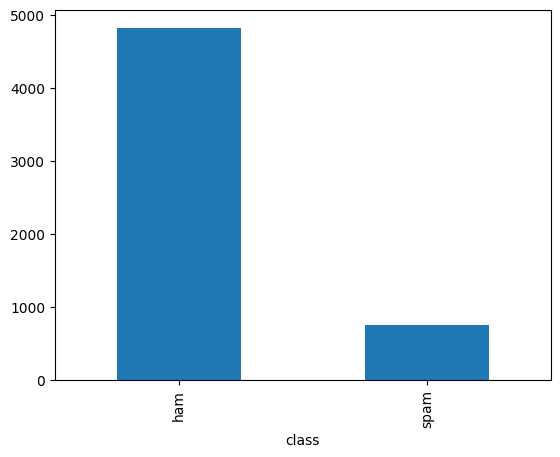

In [19]:
corpus_counts.plot.bar()

<Axes: xlabel='Predicted Topic', ylabel='Predicted Topic Probability'>

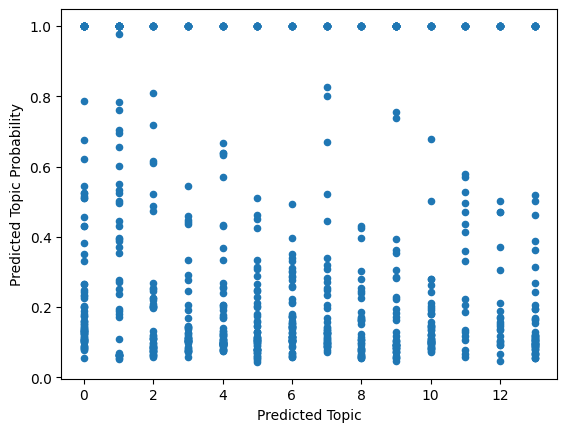

In [20]:
train_topics_probs_df.plot.scatter(x="Predicted Topic", y="Predicted Topic Probability")

<Axes: title={'center': 'Topic Frequencies'}, xlabel='Predicted Topic', ylabel='Frequency'>

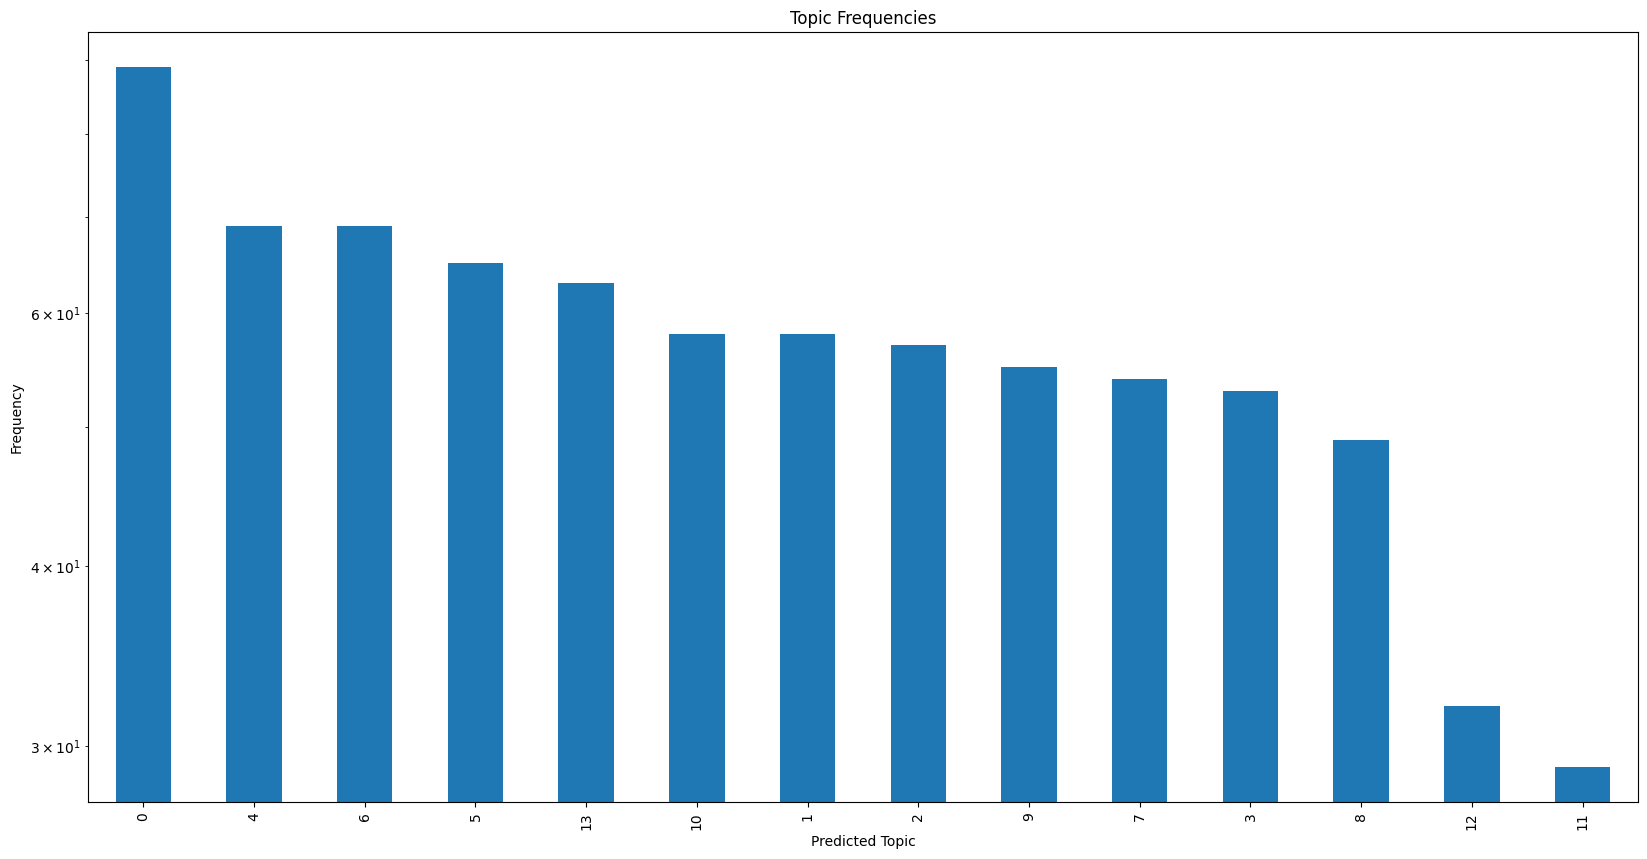

In [21]:
train_topics_probs_df["Predicted Topic"]\
  .value_counts()\
  .plot\
  .bar(logy=True, figsize=(20, 10), xlabel="Predicted Topic", ylabel="Frequency", title="Topic Frequencies")

<Axes: title={'center': 'Topic Frequencies'}, xlabel='Assigned Topic', ylabel='Frequency'>

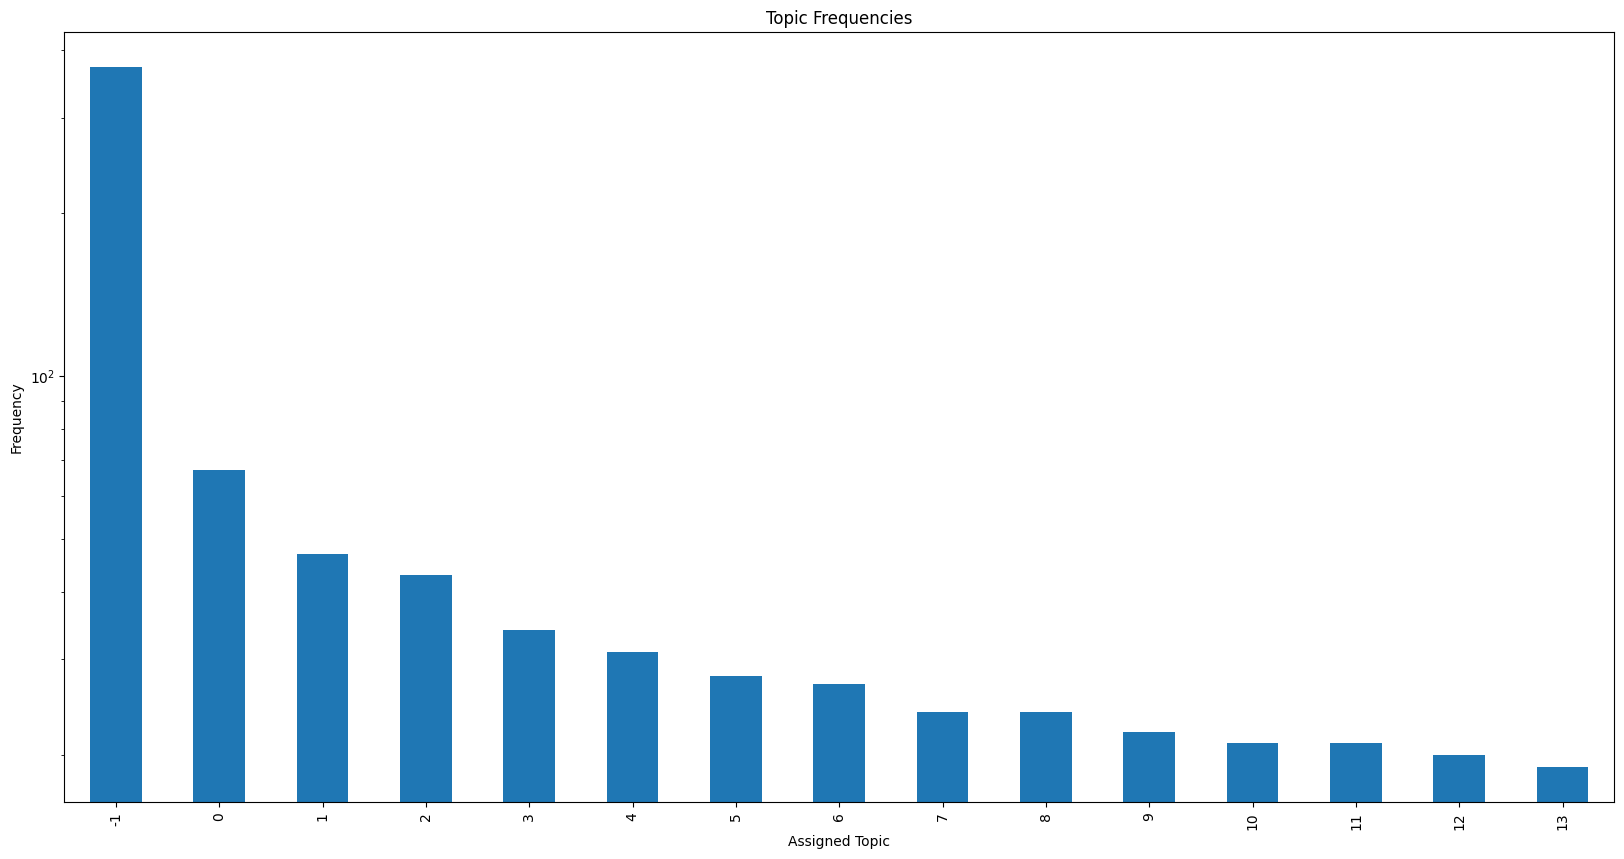

In [22]:
train_topics_probs_df["Assigned Topic"]\
  .value_counts()\
  .plot\
  .bar(logy=True, figsize=(20, 10), xlabel="Assigned Topic", ylabel="Frequency", title="Topic Frequencies")

# Classification

## Models

### Unsupervised

In [23]:
# takes in a pd.Series, pd.DataFrame and returns an np.array
km_pipeline = make_pipeline(
    KMeans(n_clusters=2, random_state=random_state)
)

In [24]:
# takes in a pd.Series, pd.DataFrame and returns an np.array
spectral_pipeline = make_pipeline(
    SpectralClustering(n_clusters=2, random_state=random_state)
)

### Supervised

In [121]:
# takes in a pd.Series, pd.DataFrame and returns an np.array
knn_pipeline = make_pipeline(
    KNeighborsClassifier(n_neighbors=5)
)

In [123]:
# takes in a pd.Series, pd.DataFrame and returns an np.array
nb_pipeline = make_pipeline(
    GaussianNB()
)

## Important Functions

In [140]:
def get_spam_scores(training_vects, training_classes, testing_vects, testing_classes):
    baseline = [0] * len(testing_classes)
    bias = 0.1

    # #get a mask of the sms's longer than minSusLen
    # text_len_mask = test["text"].apply(len).ge(minSusLen)
    # #add the excess length * the weight to the total score
    # scores[text_len_mask] = scores[text_len_mask].add((test["text"]).multiply(lenWeight))



    # get unsupervised models' predictions
    km_predictions = pd.Series(data = km_pipeline.fit_predict(testing_vects))\
                          .astype(int)
    spectral_predictions = pd.Series(data = spectral_pipeline.fit_predict(testing_vects))\
                                .astype(int)

    # get supervised models' predictions
    knn_pipeline.fit(training_vects, training_classes)
    knn_predictions = pd.Series(data = knn_pipeline.predict(testing_vects))\
                          .astype(int)
    nb_pipeline.fit(training_vects.toarray(), training_classes)
    nb_predictions = pd.Series(data = knn_pipeline.predict(testing_vects))\
                          .astype(int)


    # combine into 1 dataframe and cast to correct type
    scores = pd.DataFrame({
        "baseline": baseline,
        "K Means": km_predictions,
        "Spectral Clustering": spectral_predictions,
        "K Nearest Neighbor": knn_predictions,
        "Naive Bayes": nb_predictions
    }).dropna()

    scores = scores.add(bias)

    scores[scores > 0.5] = 1
    scores[scores < 0.5] = 0
    return scores.astype(int)

## Classify

In [141]:
print(all_train_vects.shape)
print(all_test_vects.shape)

(800, 391)
(201, 391)


In [142]:
predictions = get_spam_scores(\
                              all_train_vects,\
                              train["class"],\
                              all_test_vects,\
                              test["class"]
)
predictions.head()

,baseline,K Means,Spectral Clustering,K Nearest Neighbor,Naive Bayes
0,0,0,0,0,0
1,0,0,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,0,1,0,0


In [143]:
actual = pd.DataFrame(data=corpus["class"])
actual.columns = ["actual"]
actual.head()

,actual
0,0
1,1
2,0
3,0
4,1


In [144]:
expected_and_predictions = pd.concat([actual, predictions], axis=1, ignore_index=True).dropna()
expected_and_predictions.columns = ["actual"] + list(predictions.columns)
expected_and_predictions

,actual,baseline,K Means,Spectral Clustering,K Nearest Neighbor,Naive Bayes
0,0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0
2,0,0.0,1.0,0.0,0.0,0.0
3,0,0.0,1.0,0.0,0.0,0.0
4,1,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
196,0,0.0,1.0,0.0,0.0,0.0
197,0,0.0,0.0,1.0,0.0,0.0
198,0,0.0,1.0,0.0,0.0,0.0
199,0,0.0,1.0,0.0,0.0,0.0


# Model Comparison

In [145]:
def format(stat):
    return "\t" + str('%.3f'%stat)

K Means scores:
Mean Squared Error		0.577
Mean Absolute Error		0.577
False Positive Rate		0.837
False Negative Rate		0.077
Accuracy			0.423
Precision			0.163
Recall				0.606
F1				0.256


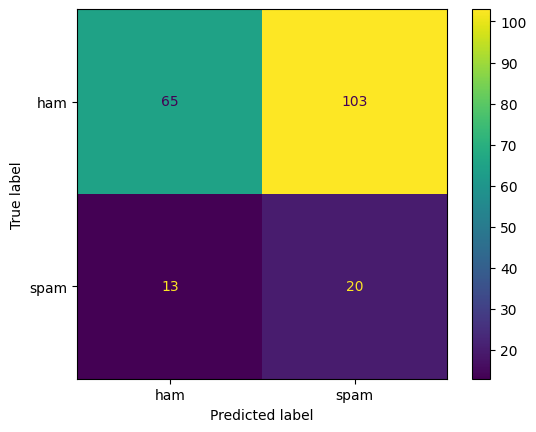


K Nearest Neighbor scores:
Mean Squared Error		0.174
Mean Absolute Error		0.174
False Positive Rate		1.000
False Negative Rate		0.196
Accuracy			0.826
Precision			0.000
Recall				0.000
F1				0.000


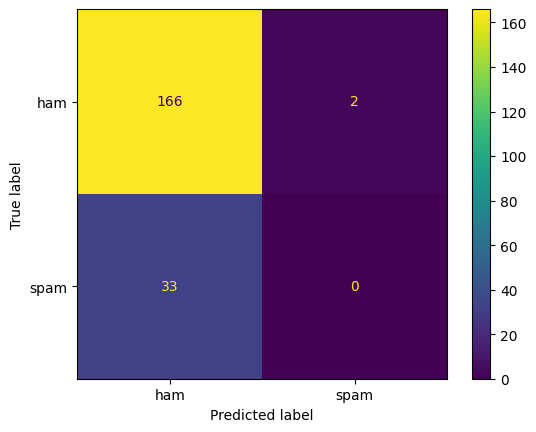


Naive Bayes scores:
Mean Squared Error		0.174
Mean Absolute Error		0.174
False Positive Rate		1.000
False Negative Rate		0.196
Accuracy			0.826
Precision			0.000
Recall				0.000
F1				0.000


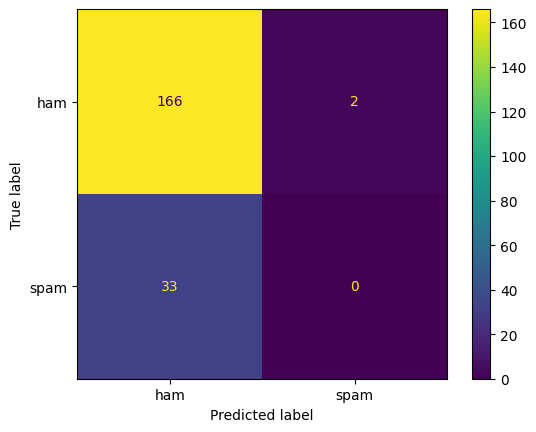


Spectral Clustering scores:
Mean Squared Error		0.299
Mean Absolute Error		0.299
False Positive Rate		0.814
False Negative Rate		0.149
Accuracy			0.701
Precision			0.186
Recall				0.242
F1				0.211


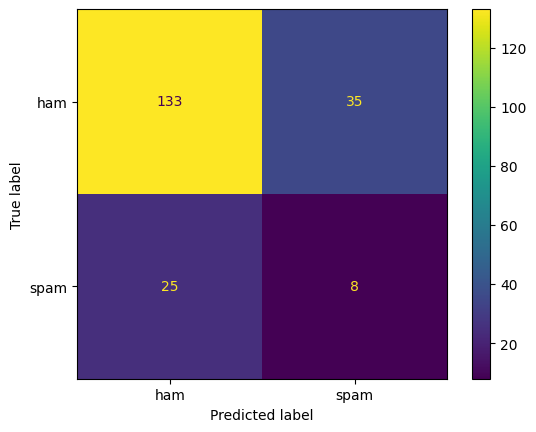


baseline scores:
Mean Squared Error		0.164
Mean Absolute Error		0.164
False Positive Rate		nan
False Negative Rate		0.196
Accuracy			0.836
Precision			0.000
Recall				0.000
F1				0.000


<ipython-input-146-e6c521d395cd>:13: RuntimeWarning: invalid value encountered in scalar divide
  "False Positive Rate\t": confusion[0][1]/confusion.sum(axis=0)[1],


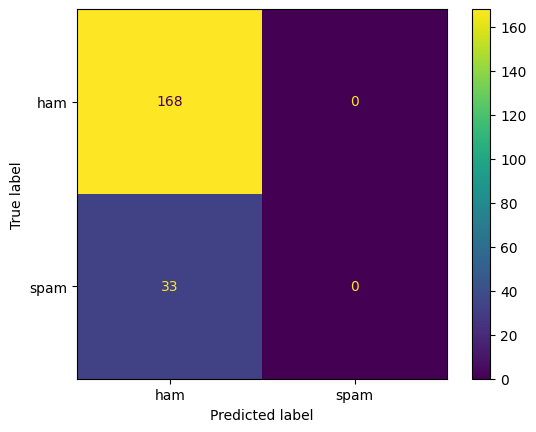

In [146]:
# get scoring metrics
scores = {}
scores_df = pd.DataFrame()
model_names = sorted(list(set(expected_and_predictions.columns) - {"actual"}))

for model_name in model_names:

    confusion = confusion_matrix(expected_and_predictions["actual"], expected_and_predictions[model_name])

    scores[model_name] = {
        "Mean Squared Error\t": mean_squared_error(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "Mean Absolute Error\t":  mean_absolute_error(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "False Positive Rate\t": confusion[0][1]/confusion.sum(axis=0)[1],
        "False Negative Rate\t": confusion[1][0]/confusion.sum(axis=1)[0],
        "Accuracy\t\t": accuracy_score(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "Precision\t\t": precision_score(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "Recall\t\t\t":  recall_score(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "F1\t\t\t":  f1_score(expected_and_predictions["actual"], expected_and_predictions[model_name])
    }

    print(model_name + " scores:")

    for metric, value in scores[model_name].items():
        print(metric + format(value))

    confusion_display = ConfusionMatrixDisplay(confusion, display_labels=["ham", "spam"])
    confusion_display.plot()
    plt.show()

    print()

In [147]:
mislabelled_sms = expected_and_predictions[model_names]
mislabelled_sms["mean pred class"] = mislabelled_sms.mean(axis=1)

col_names = list(mislabelled_sms.columns) + ["class", "text"]
mislabelled_sms = pd.concat([mislabelled_sms, test], axis=1, ignore_index=True)
mislabelled_sms.columns = col_names

In [148]:
mislabelled_sms.head()

,K Means,K Nearest Neighbor,Naive Bayes,Spectral Clustering,baseline,mean pred class,class,text
0,0.0,0.0,0.0,0.0,0.0,0.0,0,Ok i will tell her to stay out. Yeah its been ...
1,0.0,0.0,0.0,0.0,0.0,0.0,0,4 oclock at mine. Just to bash out a flat plan.
2,1.0,0.0,0.0,0.0,0.0,0.2,0,Welp apparently he retired
3,1.0,0.0,0.0,0.0,0.0,0.2,0,Wow. I never realized that you were so embaras...
4,0.0,0.0,0.0,1.0,0.0,0.2,0,That is wondar full flim.


In [149]:
mislabelled_sms = mislabelled_sms[abs(mislabelled_sms["class"] - mislabelled_sms["mean pred class"]) > 0.5]
mislabelled_sms

,K Means,K Nearest Neighbor,Naive Bayes,Spectral Clustering,baseline,mean pred class,class,text
5,0.0,0.0,0.0,0.0,0.0,0.0,1,"SMSSERVICES. for yourinclusive text credits, p..."
12,1.0,0.0,0.0,0.0,0.0,0.2,1,GENT! We are trying to contact you. Last weeke...
17,0.0,0.0,0.0,0.0,0.0,0.0,1,Urgent UR awarded a complimentary trip to Euro...
18,1.0,0.0,0.0,0.0,0.0,0.2,1,To review and KEEP the fantastic Nokia N-Gage ...
19,0.0,0.0,0.0,1.0,0.0,0.2,1,Congrats! 1 year special cinema pass for 2 is ...
23,1.0,0.0,0.0,0.0,0.0,0.2,1,U 447801259231 have a secret admirer who is lo...
25,0.0,0.0,0.0,0.0,0.0,0.0,1,U are subscribed to the best Mobile Content Se...
33,0.0,0.0,0.0,0.0,0.0,0.0,1,Email AlertFrom: Jeri StewartSize: 2KBSubject:...
35,0.0,0.0,0.0,1.0,0.0,0.2,1,England v Macedonia - dont miss the goals/team...
46,1.0,0.0,0.0,0.0,0.0,0.2,1,SMS. ac Sptv: The New Jersey Devils and the De...
